In [1]:
# Importing the required modules

In [2]:
pip install Catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Anantapur']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
0,0,14.08,77.69,Anantapur,Penukonda,Gonipeta,Mixed soil,6.19,0.07,0.18,7.13,41.0,587.0,101.0,5.16,0.30,0.17,8.89,0.51,15.24,0.312311,0.090286,0.535080,1.609966,-0.445978,G.Nut
1,1,14.09,77.69,Anantapur,Penukonda,Gonipeta,Redsoil,8.40,0.33,0.31,10.34,102.0,811.0,261.0,9.91,0.36,0.57,3.24,0.44,6.90,0.127815,-0.068606,0.187032,0.845618,-0.297165,G.Nut
2,2,14.09,77.69,Anantapur,Penukonda,Gonipeta,Mixed soil,7.10,0.11,0.17,8.46,46.0,582.0,48.0,3.77,0.37,0.19,5.54,0.42,8.34,0.127815,-0.068606,0.187032,0.845618,-0.297165,G.Nut
3,3,14.10,77.70,Anantapur,Penukonda,Gonipeta,Sandi soil,8.30,0.21,0.20,2.31,35.0,3048.0,52.0,4.14,0.23,0.21,1.79,0.67,4.17,0.140598,-0.065553,0.198200,0.984709,-0.329918,Horsegram
4,4,14.09,77.69,Anantapur,Penukonda,Gonipeta,Mixed soil,6.40,0.06,0.22,6.08,76.0,511.0,84.0,1.45,0.36,0.22,22.26,0.45,9.20,0.127815,-0.068606,0.187032,0.845618,-0.297165,Horsegram


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'NDVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,7.651929,0.192857,0.289500,6.512429,80.771429,1725.871429,206.078571,9.862571,0.404643,0.469214,5.762143,0.661286,8.165786,-0.021194
std,0.998730,0.236054,0.185656,11.774011,41.004183,992.319243,191.302768,20.594145,0.407398,0.346146,4.518472,0.323007,5.464037,0.082512
min,5.200000,0.030000,0.060000,1.180000,23.000000,166.000000,19.000000,1.060000,0.100000,0.150000,0.790000,0.200000,1.630000,-0.106673
25%,6.837500,0.080000,0.177500,2.140000,53.750000,823.750000,85.500000,2.800000,0.210000,0.250000,2.540000,0.457500,4.025000,-0.068606
50%,8.150000,0.130000,0.230000,3.615000,68.500000,1511.000000,146.000000,3.930000,0.300000,0.330000,4.290000,0.560000,7.020000,-0.053319
75%,8.385000,0.200000,0.360000,7.595000,97.500000,2651.000000,254.500000,6.360000,0.460000,0.547500,7.892500,0.780000,10.340000,0.014395
max,9.020000,1.610000,1.410000,132.060000,265.000000,4097.000000,1179.000000,181.160000,3.390000,2.380000,27.920000,1.920000,29.670000,0.574309


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Mixed soil', 'Redsoil', 'Sandi soil', 'Red soil', 'Black Soil',
       'Sandy soil', 'RED', 'BLACK'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Redsoil', 'RED', 'Red soil'], 'Red Soil')
df['SoilType'] = df['SoilType'].replace('BLACK', 'Black Soil')
df['SoilType'] = df['SoilType'].replace(['Sandi soil', 'Sandy soil'], 'Sandy Soil')
df['SoilType'] = df['SoilType'].replace('Mixed soil', 'Mixed Soil')
df.SoilType.unique()

array(['Mixed Soil', 'Red Soil', 'Sandy Soil', 'Black Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 10, 'Mixed Soil': 12, 'Red Soil': 112, 'Sandy Soil': 6}

<BarContainer object of 4 artists>

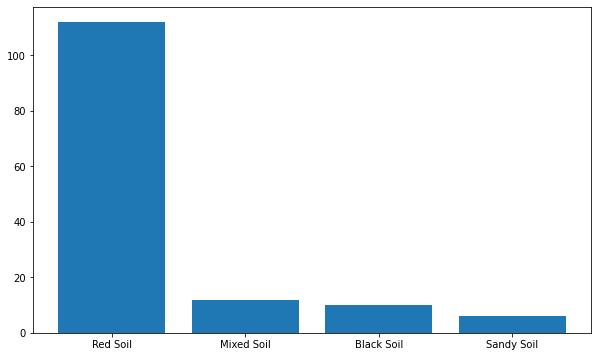

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['G.Nut', 'Horsegram', 'jowar', 'cotton', 'GROUND NUT', 'SUNFLOWER',
       'PADDY', 'TAMATO'], dtype=object)

In [15]:
df['Crop'].value_counts()

G.Nut         102
Horsegram      16
GROUND NUT     14
TAMATO          3
PADDY           2
cotton          1
jowar           1
SUNFLOWER       1
Name: Crop, dtype: int64

GroundNut    116
HorseGram     16
Tomato         3
Paddy          2
Name: Crop, dtype: int64


<BarContainer object of 4 artists>

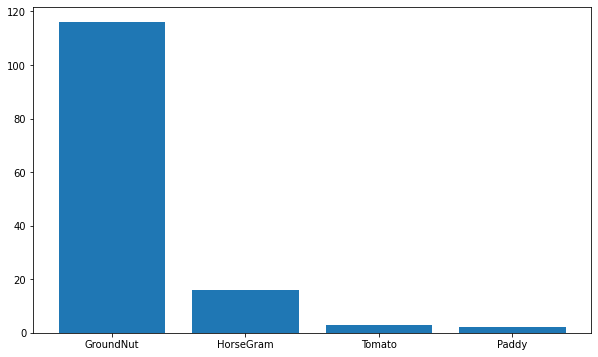

In [16]:
df['Crop'] = df['Crop'].replace(['G.Nut', 'GROUND NUT'], 'GroundNut')
df['Crop'] = df['Crop'].replace(['Horsegram'], 'HorseGram')
df['Crop'] = df['Crop'].replace(['TAMATO'], 'Tomato')
df['Crop'] = df['Crop'].replace(['PADDY'], 'Paddy')
df = df[(df['Crop'] != 'jowar') & (df['Crop'] != 'cotton') & (df['Crop'] != 'SUNFLOWER')]
print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
df = df[(df["Crop"] != 'Tomato') & (df["Crop"] != 'Paddy')]

In [18]:
# Getting rid of features that have a high correlation among one another

In [19]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
pH,1.000000,0.324521,0.246057,0.096174,0.270055,0.738869,0.333925,0.181708,0.128388,0.445603,-0.384213,0.163669,-0.604875,0.084843
EC,0.324521,1.000000,0.353826,0.536092,0.327708,0.382661,0.686467,0.917043,0.265468,0.445855,0.133792,0.346147,-0.144486,-0.035272
OC,0.246057,0.353826,1.000000,0.294536,0.533999,0.275270,0.583832,0.309083,0.380516,0.627248,0.203830,0.454423,-0.048781,0.117027
P,0.096174,0.536092,0.294536,1.000000,0.468772,0.110360,0.480357,0.704298,0.265371,0.299007,0.309679,0.349615,-0.016899,-0.024217
K,0.270055,0.327708,0.533999,0.468772,1.000000,0.210341,0.500043,0.342663,0.225943,0.534825,0.183104,0.420192,-0.122099,0.117302
Ca,0.738869,0.382661,0.275270,0.110360,0.210341,1.000000,0.405896,0.254760,0.009658,0.352852,-0.186718,0.375051,-0.453159,0.163301
Mg,0.333925,0.686467,0.583832,0.480357,0.500043,0.405896,1.000000,0.700722,0.209486,0.625129,0.259137,0.563011,-0.199968,0.075066
S,0.181708,0.917043,0.309083,0.704298,0.342663,0.254760,0.700722,1.000000,0.177975,0.405801,0.276201,0.361188,-0.057399,-0.080653
Zn,0.128388,0.265468,0.380516,0.265371,0.225943,0.009658,0.209486,0.177975,1.000000,0.379540,0.045797,0.051484,0.034093,-0.149380
B,0.445603,0.445855,0.627248,0.299007,0.534825,0.352852,0.625129,0.405801,0.379540,1.000000,0.058007,0.405252,-0.284042,0.167273


In [20]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['P', 'K', 'Ca', 'Mg', 'S', 'B', 'Cu']


In [21]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'Zn', 'Fe', 'Mn', 'ARVI', 'Crop']


In [22]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [23]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
X = X.values
y = y.values
print(type(X[0]))

     pH    EC    OC   Zn  ...  Black Soil  Mixed Soil  Red Soil  Sandy Soil
0  6.19  0.07  0.18  0.3  ...           0           1         0           0

[1 rows x 11 columns]
<class 'numpy.ndarray'>


In [24]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
print(X[0])
X[:,0:7] = sc1.fit_transform(X[:,0:7])
print(X[0])

[ 6.19        0.07        0.18        0.3         8.89       15.24
  0.09028571  0.          1.          0.          0.        ]
[-1.4324609  -0.52831773 -0.58362014 -0.27682486  0.6931062   1.3388061
  1.34855283  0.          1.          0.          0.        ]


In [25]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [26]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [27]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [28]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8484848484848485


In [29]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 83.89 %
Standard Deviation: 4.77 %


# Decision Tree Classifier

In [30]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [31]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [32]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.9090909090909091


In [33]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 85.00 %
Standard Deviation: 12.04 %


# Random Forest Classifier

In [34]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [35]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [36]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8787878787878788


In [37]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 87.89 %
Standard Deviation: 5.97 %


In [38]:
# pickle.dump(clf3, open('Anantapur_model.pkl', 'wb'))
# pickle.dump(sc1, open('Anantapur_scaler.pkl', 'wb'))
# HERE

# XGBoost

In [39]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [40]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [41]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  0.98989898989899
Testing Accuracy:  0.8181818181818182


In [42]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [43]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 82.89 %
Standard Deviation: 10.93 %


# Multi-layer Perceptron Classifier

In [44]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [45]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [46]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.898989898989899
Testing Accuracy:  0.8484848484848485


In [47]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 87.89 %
Standard Deviation: 3.96 %


# Catboost

In [48]:
# Catboost

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.3984355	total: 46.4ms	remaining: 4.6s
1:	learn: 0.3216367	total: 47.5ms	remaining: 2.33s
2:	learn: 0.2827406	total: 48ms	remaining: 1.55s
3:	learn: 0.2737687	total: 48.7ms	remaining: 1.17s
4:	learn: 0.2617602	total: 49.3ms	remaining: 936ms
5:	learn: 0.2525315	total: 49.8ms	remaining: 781ms
6:	learn: 0.2396632	total: 50.5ms	remaining: 671ms
7:	learn: 0.2144023	total: 51ms	remaining: 587ms
8:	learn: 0.2014205	total: 51.6ms	remaining: 521ms
9:	learn: 0.1721106	total: 52.1ms	remaining: 469ms
10:	learn: 0.1610332	total: 52.6ms	remaining: 426ms
11:	learn: 0.1528715	total: 53.1ms	remaining: 390ms
12:	learn: 0.1430083	total: 53.7ms	remaining: 359ms
13:	learn: 0.1336239	total: 54.3ms	remaining: 333ms
14:	learn: 0.1273908	total: 54.9ms	remaining: 311ms
15:	learn: 0.1217719	total: 55.4ms	remaining: 291ms
16:	learn: 0.1197403	total: 56ms	remaining: 273ms
17:	learn: 0.1167869	total: 56.6ms	remaining: 258ms
18:	learn: 0.1117645	total: 57.1ms	remaining: 243ms
19:	learn: 0.1071787	total: 5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4222504261
bestIteration = 76

Training on fold [1/5]

bestTest = 0.4149005412
bestIteration = 89

Training on fold [2/5]

bestTest = 0.345672129
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3250811065
bestIteration = 99

Training on fold [4/5]

bestTest = 0.33656137
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 0.6571127	total: 1.81ms	remaining: 603ms
3:	learn: 0.6448155	total: 2.5ms	remaining: 622ms
4:	learn: 0.6347503	total: 3.19ms	remaining: 635ms
5:	learn: 0.6242445	total: 3.92ms	remaining: 649ms
6:	learn: 0.6146452	total: 4.64ms	remaining: 658ms
7:	learn: 0.6043421	total: 5.38ms	remaining: 667ms
8:	learn: 0.5951163	total: 6.15ms	remaining: 678ms
9:	learn: 0.5850004	total: 6.87ms	remaining: 680ms
10:	learn: 0.5776462	total: 7.6ms	remaining: 683ms
11:	learn: 0.5697707	total: 8.31ms	remaining: 684ms
12:	learn: 0.5625555	total: 9.11ms	remaining: 692ms
13:	learn: 0.5537191	total: 9.86ms	remaining: 694ms
14:	learn: 0.5465807	total: 10.5ms	remaining: 692ms
15:	learn: 0.5386168	total: 11.2ms	remaining: 688ms
16:	learn: 0.5304476	total: 11.9ms	remaining: 687ms
17:	learn: 0.5236990	total: 12.5ms	remaining: 684ms
18:	learn: 0.5160691	total: 13.2ms	remaining: 683ms
19:	learn: 0.5089364	total: 13.9ms	remaining: 682ms
20:	learn: 0.5029483	to